In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Added ReduceLROnPlateau for learning rate scheduling
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from typing import Literal
from pathlib import Path
from PIL import Image

In [9]:
def evaluate_model():
    # === Evaluate the Model ===
    # Get predictions from the model
    y_pred = model.predict(X_test)  # Predict on X_test
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions (argmax for the softmax output)
    
    # Convert y_test from one-hot encoding to integer labels (healthy = 0, COVID/symptomatic = 1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # === Compute confusion matrix ===
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    # === Print classification report ===
    print("Classification Report:")
    print(classification_report(
        y_test_classes,
        y_pred_classes,
        target_names=['healthy', 'symptomatic or COVID']
    ))
    
    # === (Optional) Plot the confusion matrix ===
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    
    # Define the class labels
    classes = ['healthy', 'symptomatic or COVID']
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='Predicted label',
        ylabel='True label',
        title='Confusion Matrix'
    )
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Annotate counts in each cell of the confusion matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    
    plt.tight_layout()
    plt.show()

In [4]:
X = np.load("X_128x128.npy", allow_pickle=True)
y = np.load("y_128x128.npy", allow_pickle=True)
np.sum(y, axis=0)

# Assuming y is one-hot encoded with 3 classes: 
# y = [[1, 0, 0],  # COVID
#      [0, 1, 0],  # Healthy
#      [0, 0, 1]]  # Symptomatic

# Step 1: Convert y to integer labels (0 for COVID, 1 for Healthy, 2 for Symptomatic)
y_combined = np.argmax(y, axis=1)  # This will give us an array of indices: 0, 1, or 2

# Step 2: Combine symptomatic (class 2) and COVID (class 0) into one category (class 1), leave healthy (class 1) as it is
new_y = np.where(np.isin(y_combined, [0, 2]), 1, 0)  # Map COVID and Symptomatic to class 1, healthy to class 0

# Step 3: Convert the new labels to one-hot encoding (2 classes: healthy vs symptomatic or COVID)
new_y = np.array([[1, 0] if label == 0 else [0, 1] for label in new_y])

# Verify the shape of the new y
print(f"new_y shape: {new_y.shape}")  # It should be (n_samples, 2)

# Check the first few rows of the new_y to confirm it's correct
print(new_y[:10])  # Display the first 10 rows to check

# Sum the COVID
covid_and_symptomatic_sum = np.sum(new_y[:,1])

print(f"Total number of COVID or symptomatic cases: {covid_and_symptomatic_sum}")

# Sum the Healthy 
healthy_sum = np.sum(new_y[:,0])

print(f"Total number of healthy cases: {healthy_sum}")

new_y shape: (20664, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]
Total number of COVID or symptomatic cases: 5188
Total number of healthy cases: 15476


In [5]:
# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, new_y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42
)

# === Convert X and y to appropriate formats ===
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [11]:
# Define Focal Loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        
        # Calculate cross-entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Apply the focal loss formula
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    
    return focal_loss_fixed

# === CNN Model Definition ===
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Global Average Pooling instead of Flattening
    GlobalAveragePooling2D(),
    
    # Dropout to prevent overfitting
    Dropout(0.5),  # Increase dropout

    # Fully Connected Layer
    Dense(128, activation='relu'),
    
    # Output Layer (2 classes: healthy and symptomatic_or_COVID)
    Dense(2, activation='softmax')
])

# === Calculate Class Weights ===
class_weights = {0: .6, 1: 2.2}  # Healthy: 0, Symptomatic or COVID: 2

# === Compile the model with Focal Loss ===
model.compile(optimizer=Adam(learning_rate=0.0005), loss=focal_loss(gamma=1.25, alpha=0.25), metrics=['accuracy'])

# === Early Stopping Callback ===
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=7,  # Patience increased to 7 epochs
    restore_best_weights=True
)

# === Learning Rate Scheduling ===
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,  # Reduce learning rate by 30%
    patience=2,  # Wait for 2 epochs without improvement before reducing LR
    min_lr=1e-6  # Lower bound for the learning rate
)

# === Train the Model with Class Weights ===
history = model.fit(
    X_train, y_train,
    epochs=30,  # Use a higher number of epochs to allow the model to learn better
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,  # Pass class weights here
    callbacks=[early_stopping, reduce_lr]
)

# === Evaluate Model ===
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 89s 190ms/step - accuracy: 0.4363 - loss: 0.0822 - val_accuracy: 0.2491 - val_loss: 0.0791 - learning_rate: 5.0000e-04
Epoch 2/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 85s 183ms/step - accuracy: 0.3608 - loss: 0.0737 - val_accuracy: 0.5659 - val_loss: 0.0726 - learning_rate: 5.0000e-04
Epoch 3/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.3524 - loss: 0.0728 - val_accuracy: 0.2491 - val_loss: 0.0781 - learning_rate: 5.0000e-04
Epoch 4/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 89s 191ms/step - accuracy: 0.3330 - loss: 0.0723 - val_accuracy: 0.2890 - val_loss: 0.0759 - learning_rate: 5.0000e-04
Epoch 5/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - accuracy: 0.2852 - loss: 0.0725 - val_accuracy: 0.3875 - val_loss: 0.0753 - learning_rate: 1.5000e-04
Epoch 6/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - accuracy: 0.3265 - loss: 0.0720 - val_accuracy: 0.2963 - val_loss: 0.0779 - learning_rate: 1.5000e-04
Epoch 7/30
465/465 ━━━━━━━━━━━━━━━━━━━━ 83s 17

130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Classification Report:
                      precision    recall  f1-score   support

             healthy       0.76      0.56      0.64      3095
symptomatic or COVID       0.26      0.46      0.33      1038

            accuracy                           0.54      4133
           macro avg       0.51      0.51      0.49      4133
        weighted avg       0.63      0.54      0.57      4133



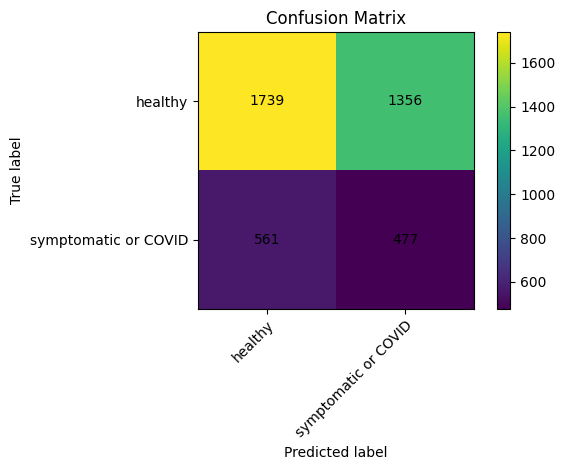

In [12]:
evaluate_model()